# LPPLS-CI for Tactical Asset Allocation
---

## Contents
- Introduction
- General Imports and Constants
- Fetching Universe Data (Yahoo! Finance)
- Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns
- Construct the Bubble Portfolio
- QuantStats Performance Metrics

## Introduction
In this notebook I compare the performance of two portfolios: an equally weighted portfolio and a portfolio whose weights are determined by a bubble indicator. The backtest runs from from January 30, 2004 through June 30, 2021. The portfolios are constructed from the following intstruments. 

|ETF Ticker|Allocation|Underlying Asset|Description|
|:---------|:---------|:---------------|:----------|
|[VTI](https://investor.vanguard.com/etf/profile/VTI)|20%|Equity|Seeks to track the performance of the CRSP US Total Market Index. Large-, mid-, and small-cap equity diversified across growth and value styles.|
|[VTV](https://investor.vanguard.com/etf/profile/VTV)|20%|Equity|Seeks to track the performance of the CRSP US Large Cap Value Index, which measures the investment return of large-capitalization value stocks.|
|[VBR](https://investor.vanguard.com/etf/profile/VBR)|20%|Equity|Seeks to track the performance of the CRSP US Small Cap Value Index, which measures the investment return of small-capitalization value stocks.|
|[TLT](https://www.ishares.com/us/products/239454/ishares-20-year-treasury-bond-etf)|20%|Debt|The iShares 20+ Year Treasury Bond ETF seeks to track the investment results of an index composed of U.S. Treasury bonds with remaining maturities greater than twenty years.|
|[AGG](https://www.ishares.com/us/products/239458/ishares-core-total-us-bond-market-etf)|20%|Debt|The iShares Core U.S. Aggregate Bond ETF seeks to track the investment results of an index composed of the total U.S. investment-grade bond market.|

Since the equally weighted portfolio represents 60% equities and 40% debt, a fair benchmark could be 60% VTI (Total Equity Market) and 40% AGG (Total Bond Market). This benchmark is created in the **Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns** section. 

## General Imports and Constants
Below I load the third party libraries for use in the project. Note that the `utils` import includes much of the helper functions used in the notebook.

I also define a few of the constants used throughout the notebook.

In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
from lppls import lppls
import numpy as np
from os.path import exists
import pandas as pd
import time
import yfinance as yf
import quantstats as qs

START = '2004-01-30'
END = '2021-11-24'
LOOKBACK = 21 * 6 # 21 days in a trading month
UNIVERSE_CSV = 'data/universe.csv'
LPPLS_CONF_CSV = 'data/confidence.csv'
CPU_CORES = max(1, cpu_count() // 2)  # only let the LPPLS number cruncher use half the available cores
POS_BUBBLE_THRESHOLD = 0.08
NEG_BUBBLE_THRESHOLD = 0.02

## Fetching Universe Data (Yahoo! Finance)

Yahoo! Finance computes an Adjusted Closing price that factors in all splits and dividends. 
https://help.yahoo.com/kb/SLN28256.html

In [2]:
tickers = ['TLT', 'VTI', 'VTV', 'VBR', 'AGG', 'UVXY', 'SVXY'] 

if not exists(UNIVERSE_CSV):
    print('fetch data from Yahoo! Finance')
    adj_close_list = []
    for ticker in tickers:
        ticker_module = yf.Ticker(ticker)
        data = yf.download(ticker, start=START, end=END)
        adj_close = data['Adj Close']
        adj_close.rename(f'{ticker} Adj Close', inplace=True)
        adj_close_list.append(adj_close)
    # combine all dataframes into a single dataframe
    df_adj_close = pd.concat(adj_close_list, axis=1)
    df_adj_close.to_csv(UNIVERSE_CSV)
else:
    print('load data from cache')
    df_adj_close = pd.read_csv(UNIVERSE_CSV, index_col='Date', parse_dates=True)

load data from cache


## Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns

In [3]:
# get daily returns and change col names
df_pct_change = df_adj_close.pct_change().fillna(0)
df_pct_change.columns = [col.replace(' Adj Close', ' Returns') for col in df_pct_change.columns]

# call it df_D, D for Daily
df_D = df_pct_change

# create an equal weight portfolio that is rebalanced daily @ market close.
df_D['Equal Weight Portfolio Returns'] = df_D[[
    'TLT Returns', 
    'VTI Returns', 
    'VTV Returns', 
    'VBR Returns', 
    'AGG Returns'
]].mean(axis='columns')

# create a 60/40 benchmark to compare portfolio returns against through out analysis.
df_D['Benchmark Returns'] = (
    (0.6 * df_D['VTI Returns']) + (0.4 * df_D['AGG Returns'])
)
# df_D['Benchmark Returns'] = (df_D['SPY Returns'])

## Construct Bubble Portfolio
---
Is it possible to avoid the large drawdowns discovered in the drawdown analysis? Here we use the [Log-Periodic Power Law Singularity (LPPLS) Model](https://en.wikipedia.org/wiki/Didier_Sornette#The_JLS_and_LPPLS_models). It describes a bubble as a faster-than-exponential increase in asset price that reflects positive feedback loop of higher return anticipations competing with negative feedback spirals of crash expectations. A bubble has a distinct signature that resembles a power law with a finite-time singularity decorated by oscillations with a frequency increasing with time.

If we can identify bubbles in an equity benchmark, perhaps we could use that as a signal to weight our portfolio more heavily towards the less risky debt assets (AGG and TLT).

The first step is to compute the bubble indicators for the benchmark. Here I'm going to find bubbles in the VTI instrument, since it is total market.

In [4]:
# convert Date to ordinal, that's what the LPPLS model wants - it's a neat trick for curve-fitting with time-series
time_ord = [pd.Timestamp.toordinal(t1) for t1 in df_adj_close.index]

# create list of observation data
price = np.log(df_adj_close['VTI Adj Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time_ord, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the VTI data
lppls_model = lppls.LPPLS(observations=observations)

In [5]:
# compute the indicators and cache the result
if not exists(LPPLS_CONF_CSV):
    print('compute LPPLS conf scores fresh')
    # compute the confidence indicator
    res = lppls_model.mp_compute_nested_fits(
        workers=CPU_CORES,
        window_size=126*3, 
        smallest_window_size=21, 
        outer_increment=1, 
        inner_increment=5, 
        max_searches=25,
        # filter_conditions_config={} # not implemented in 0.6.x
    )
    res_df = lppls_model.compute_indicators(res)
    res_df['time'] = [pd.Timestamp.fromordinal(int(t1)) for t1 in res_df['time']]
    res_df.set_index('time', inplace=True)
    res_df.to_csv(LPPLS_CONF_CSV)
else:
    print('load LPPLS conf scores from cache')
    res_df = pd.read_csv(LPPLS_CONF_CSV, index_col='time', parse_dates=True)


load LPPLS conf scores from cache


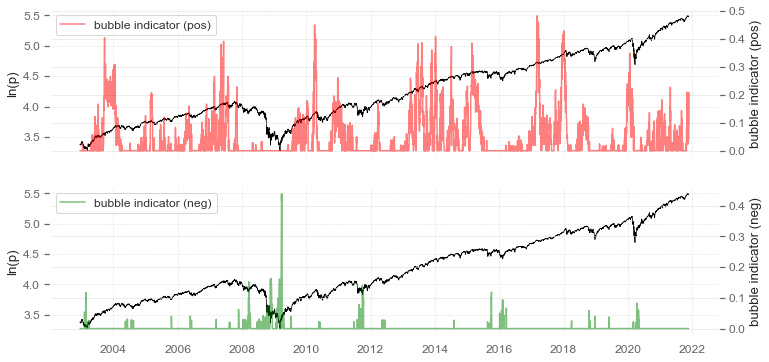

In [6]:
# visualize the conf indicator
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ts = res_df.index

# plot pos bubbles
ax1_0 = ax1.twinx()
ax1.plot(ts, res_df['price'], color='black', linewidth=0.75)
ax1_0.plot(ts, res_df['pos_conf'], label='bubble indicator (pos)', color='red', alpha=0.5)

# plot neg bubbles
ax2_0 = ax2.twinx()
ax2.plot(ts, res_df['price'], color='black', linewidth=0.75)
ax2_0.plot(ts, res_df['neg_conf'], label='bubble indicator (neg)', color='green', alpha=0.5)

# set grids
ax1.grid(which='major', axis='both', linestyle='--')
ax2.grid(which='major', axis='both', linestyle='--')

# set labels
ax1.set_ylabel('ln(p)')
ax2.set_ylabel('ln(p)')

ax1_0.set_ylabel('bubble indicator (pos)')
ax2_0.set_ylabel('bubble indicator (neg)')

ax1_0.legend(loc=2)
ax2_0.legend(loc=2)

Next we want to use this info to weight our portfolio. A simple rule could be to reduce equity exposure to 0% across the entire portfolio when the bubble confidence indicator exceeds a threshold.

In [7]:
pos_conf_df = res_df.drop(['price', '_fits'], axis=1)
bubble_portfolio_df = pos_conf_df.join(df_D)

bubble_portfolio_df['conf'] = bubble_portfolio_df['pos_conf'] - bubble_portfolio_df['neg_conf']

# prevent lookahead bias: use yesterday's conf score today 
bubble_portfolio_df['conf'] = bubble_portfolio_df['conf'].shift(2)
bp_df = bubble_portfolio_df[START:END]
# # group pos_conf by month and take the mean, 
# # @TODO: it would be better to weight most recent observations heavier
# conf_M = bubble_portfolio_df['conf'].groupby(pd.Grouper(freq='M')).mean() 

# # reintegrate monthly data to bubble_portfolio_df and forward fill the indicator, 
# # the previous month's mean pos_conf will determine what we do all next month
# bp_df = bubble_portfolio_df.join(conf_M.rename('conf_M', inplace=True))
# bp_df['conf_M'] = bp_df['conf_M'].fillna(method='ffill').fillna(0)

# construct a new portfolio with bubble weights...
conditions = [
    (bp_df['conf'] >= POS_BUBBLE_THRESHOLD), 
    (bp_df['conf'] <= -NEG_BUBBLE_THRESHOLD),
    True,
]
values = [
    (   # ⬇️ Risk Off
        (0.0 * bp_df['VTI Returns']) \
        + (0.0 * bp_df['VTV Returns']) \
        + (0.0 * bp_df['VBR Returns']) \
        + (0.5 * bp_df['AGG Returns']) \
        + (0.5 * bp_df['TLT Returns']) \
    ),( # ⬇️ Risk On
        (0.333 * bp_df['VTI Returns']) \
        + (0.333 * bp_df['VTV Returns']) \
        + (0.333 * bp_df['VBR Returns']) \
        + (0.0 * bp_df['AGG Returns']) \
        + (0.0 * bp_df['TLT Returns']) 
    ),( # ⬇️ Equal Weight
        (0.2 * bp_df['VTI Returns']) \
        + (0.2 * bp_df['VTV Returns']) \
        + (0.2 * bp_df['VBR Returns']) \
        + (0.2 * bp_df['AGG Returns']) \
        + (0.2 * bp_df['TLT Returns']) \
    )
]
bp_df['Bubble Portfolio Returns'] = np.select(conditions, values)
# bp_df['Allocation'] = np.select(conditions, [-1, 0, 1])


/Users/joshnielsen/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


If we wanted to, we could try to optimize the bubble threshold value by looking at the distribution of values. 

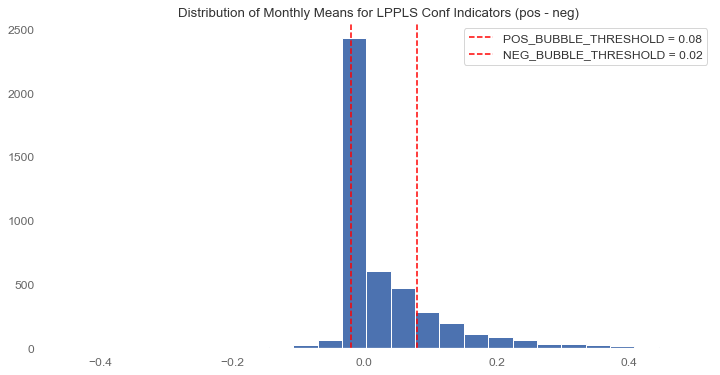

In [8]:
plt.figure(figsize=(12,6))
plt.hist(bp_df['conf'], bins=25)
plt.axvline(POS_BUBBLE_THRESHOLD, color='red', ls='--', label=f'POS_BUBBLE_THRESHOLD = {POS_BUBBLE_THRESHOLD}')
plt.axvline(-NEG_BUBBLE_THRESHOLD, color='red', ls='--', label=f'NEG_BUBBLE_THRESHOLD = {NEG_BUBBLE_THRESHOLD}')
plt.title('Distribution of Monthly Means for LPPLS Conf Indicators (pos - neg)')
plt.legend()
plt.grid()
plt.show()

## Performance Metrics

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2004-01-30  2004-01-30
End Period                 2021-11-23  2021-11-23
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          672.5%      355.39%
CAGR﹪                     12.15%      8.88%

Sharpe                     0.91        0.8
Smart Sharpe               0.84        0.74
Sortino                    1.33        1.14
Smart Sortino              1.22        1.04
Sortino/√2                 0.94        0.8
Smart Sortino/√2           0.86        0.74
Omega                      1.21        1.21

Max Drawdown               -39.31%     -34.72%
Longest DD Days            660         916
Volatility (ann.)          13.59%      11.41%
R^2                        0.8         0.8
Calmar                     0.31        0.26
Skew                       0.01        -0.34
Kurtosis                   23.83       13.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-12-11,2009-03-09,2009-10-01,660,-39.309192,-35.495741
2,2020-03-09,2020-03-18,2020-04-29,51,-17.354339,-17.221877
3,2015-03-25,2016-02-11,2016-05-27,429,-11.763138,-10.760195
4,2018-08-27,2018-12-24,2019-03-29,214,-11.743185,-9.615798
5,2011-09-19,2011-10-03,2011-10-14,25,-10.212813,-7.136001


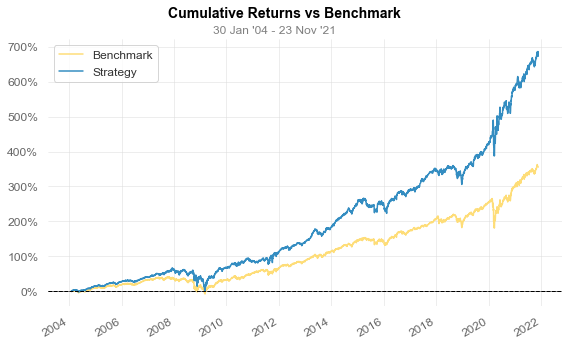

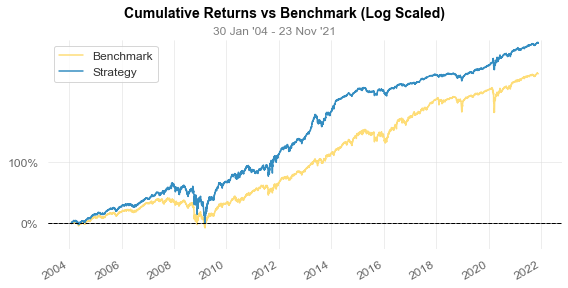

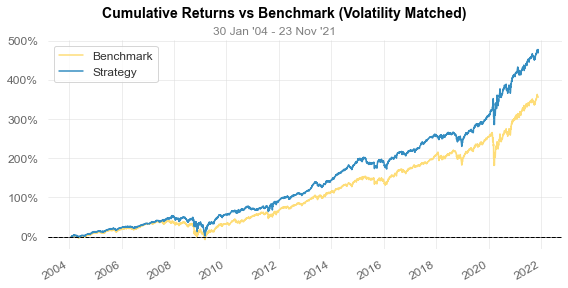

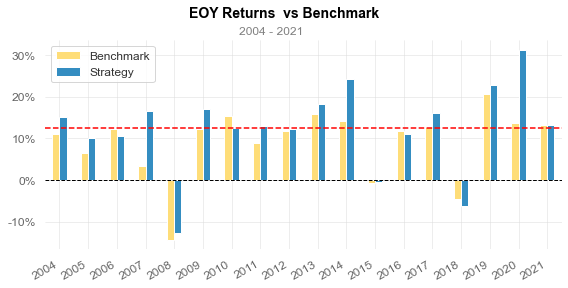

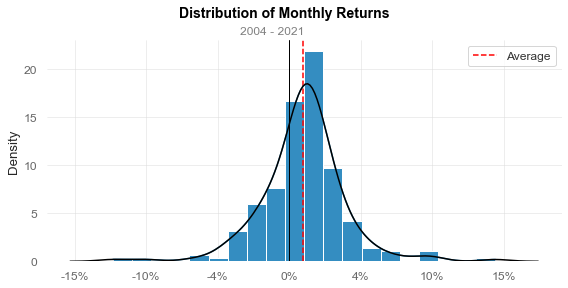

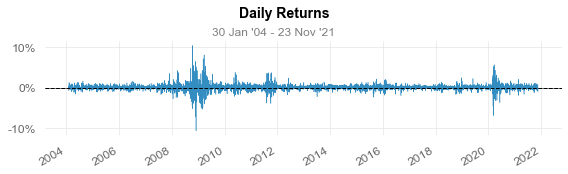

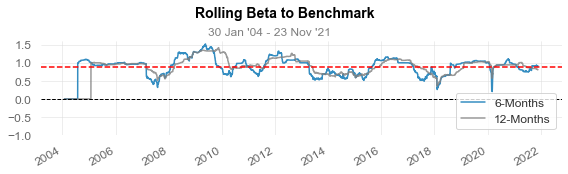

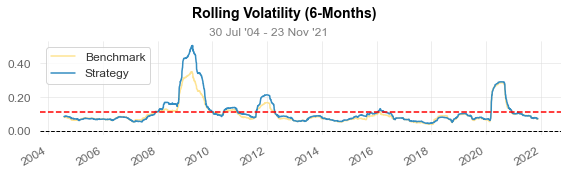

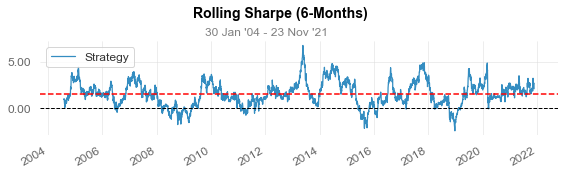

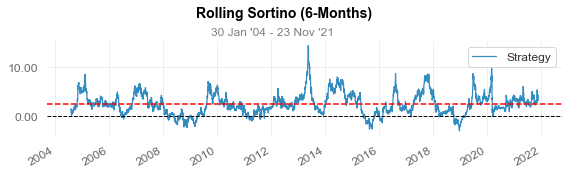

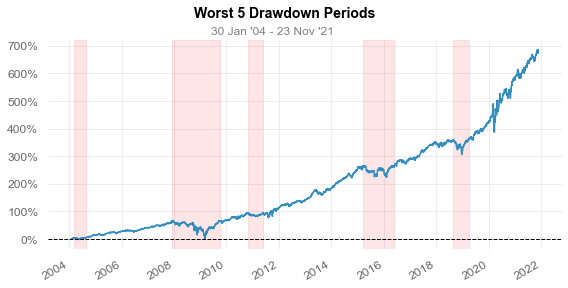

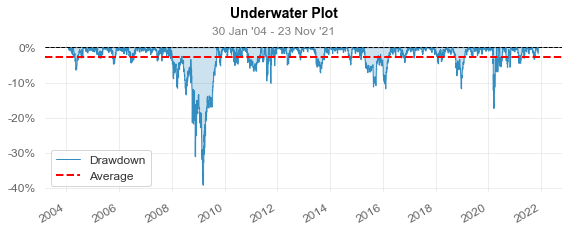

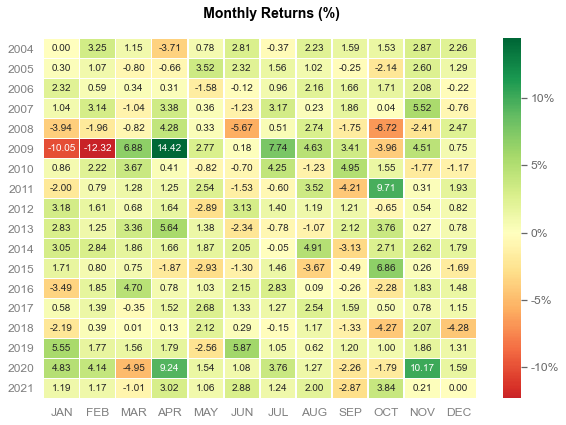

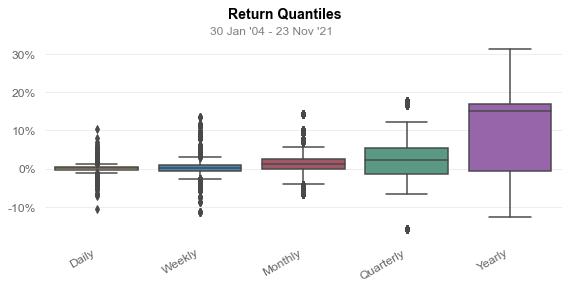

In [9]:
qs.reports.full(bp_df['Bubble Portfolio Returns'], bp_df['Equal Weight Portfolio Returns'])